In [1]:
import sys
import cv2
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
dir_path = '/root/final/main'
sys.path.append('/root/final/main')
sys.path.append('/usr/local/python/openpose')
from openpose import *

In [3]:
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x368"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.25
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu"] = 1
params["num_gpu_start"] = 1
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = "/root/final/openpose/models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

In [4]:
def get_md(point1 , point2):
    # return Manhattan Distance of point1 and point2
    # point1 and point2 are list
    test1 = np.array(point1)
    test2 = np.array(point2)
    return np.sqrt(np.sum(np.square(test1-test2)))


def get_angle(vec1,vec2):
    # return the angle of vector one to vector two 
    # negative when vec2 is in the clockwise of vec1
    #vec1 and vec2 are list
    x = np.array(vec1)
    y = np.array(vec2)
    #lenth
    Lx = np.sqrt(x.dot(x))
    Ly = np.sqrt(y.dot(y))
    cos_angle = x.dot(y)/(Lx*Ly)
    angle = np.arccos(cos_angle)
    angle2 = angle*360/2/np.pi
    crossdd = np.cross(x,y)
    if (crossdd <= 0):
        return angle2
    else:
        return -angle2


In [5]:
test10 = "squat_test1"
test11 = "squat_test2"
test12 = "squat_true"
test13 = "squat_wrong"
# the path of the video
input_path = "/root/final/main/test_video/test_video1/"
input_video = test13
input_type = ".mp4"
cap = cv2.VideoCapture(input_path+input_video+input_type)
# create the output folder
folder = os.path.exists("output_video/"+ input_video) 
if not folder:                  
    os.makedirs("output_video/"+ input_video) 
    

theta1_list = []
theta2_list = []
theta3_list = []
num_count = 0 
count = 0
index_count = [] 
while(cap.isOpened()):
    ret, frame = cap.read()  
    if frame is None:
        break;
    if count% 2==0 :
        num_count +=1 
        # following 2 lines are used for test
        frame=cv2.transpose(frame)
        frame=cv2.flip(frame,1)
        #print(frame.shape)
        #plt.imshow(frame)
        #plt.show() 
        #break
        #return the keypoints and rendered output images
        keypoints, output_image = openpose.forward(frame, True)
        # Print the human pose keypoints, i.e., a [#people x #keypoints x 3]-dimensional numpy object with the keypoints of all the people on that image
        #print(keypoints)
        #print(output_image.shape)
        #plt.imshow(output_image)
        #plt.show()
        # store the image
        temp_name = str(count)
        while(len(temp_name)!=4):
            temp_name = "0"+temp_name
        store_name = "output_video/"+ input_video + "/" + temp_name+".jpg"
        index_count.append(store_name)
        #print(store_name)
        cv2.imwrite(store_name, output_image);
        # deal with the keypoints
        [people_num , point_num, channel] = keypoints.shape
        # to choose the domaint skleton
        if (people_num != 1):
            best_index = 0
            best_dist = 0 
            for index in range(people_num):
                point1 = [keypoints[index,1,0] , keypoints[index,1,1]  ]
                point8 = [keypoints[index,8,0] , keypoints[index,8,1]  ]
                dist = get_md(point1,point8)
                if (dist > best_dist):
                    best_index = index
                    best_dist = dist
            keypoint = keypoints[best_index,:,:]
        else:
            keypoint = keypoints
        keypoint = np.squeeze(keypoint)
        # here determine whether is right or left hand
        right_hand = np.array([ math.ceil(keypoint[2,2]) ,math.ceil(keypoint[3,2]) ,math.ceil(keypoint[4,2]) ])
        left_hand = np.array([ math.ceil(keypoint[5,2]) ,math.ceil(keypoint[6,2]) ,math.ceil(keypoint[7,2]) ])
        right_confidence  = keypoint[2,2] + keypoint[3,2] + keypoint[4,2]
        left_confidence = keypoint[5,2] + keypoint[6,2] + keypoint[7,2]
        #print(right_hand,' right hand')
        #print(left_hand,' left hand')
        #print( keypoint[0,2,2] , keypoint[0,3,2] ,keypoint[0,4,2] , ' right confidence')
        #print( keypoint[0,5,2] , keypoint[0,6,2] ,keypoint[0,7,2] , ' left confidence')
        output_flag = 0 
        if ((np.sum(right_hand) == 3) & (right_confidence >= left_confidence) ):
            side = 'right'
            output_flag = 1
            shoulder_point = [keypoint[2,0] , keypoint[2,1] ]
            elbow_point = [keypoint[3,0] , keypoint[3,1] ]
            hip_point =  [keypoint[9,0] , keypoint[9,1] ] 
            knee_point =  [keypoint[10,0] , keypoint[10,1]  ] 
            ankle_point =  [keypoint[11,0] , keypoint[11,1]  ]  
        elif ((np.sum(left_hand) == 3) & (right_confidence < left_confidence) ):
            side = 'left'
            output_flag = 1
            shoulder_point = [keypoint[5,0] , keypoint[5,1] ]
            elbow_point = [keypoint[6,0] , keypoint[6,1] ]
            hip_point =  [keypoint[12,0] , keypoint[12,1] ] 
            knee_point =   [keypoint[13,0] , keypoint[13,1]  ] 
            ankle_point =  [keypoint[14,0] , keypoint[14,1]  ]
        neck_point = [keypoint[1,0] , keypoint[1,1] ]
        midhip_point = [keypoint[8,0] , keypoint[8,1] ]
        #print(side)
        # first calculate the angle between the line(neck,midhip) with vertical
        vec1 = np.array(midhip_point) - np.array(neck_point)
        vec2 = np.array([neck_point[0],neck_point[1]+2]) -np.array(neck_point)
        theta1= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta1_list.append(round(theta1))
        else:
            theta1_list.append(round(-theta1))      
        #print(theta1)
        
        # next calculate the angle between the line(hip,knee) with horizontal
        vec1 = np.array(hip_point) - np.array(knee_point)
        vec2 = np.array([knee_point[0]-2,knee_point[1]]) -np.array(knee_point)
        theta2= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta2_list.append(round(theta2))
        else:
            theta2_list.append(round(-theta2))
        #print(theta2)     
        
        # then calculate the angle between the line(elbow,shoulder) with vertical
        vec1 = np.array(shoulder_point) - np.array(elbow_point)
        vec2 = np.array([elbow_point[0],elbow_point[1]-2]) -np.array(elbow_point)
        theta3= get_angle( vec1 ,vec2 )
        if side == 'right':
            theta3_list.append(round(theta3))
        else:
            theta3_list.append(round(-theta3))
        #print(theta3)  
        
        
    count+=1
print(count)

740


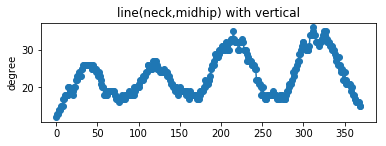

In [6]:
# post processing for mismatching
negative_count = 0
positive_count = 0 
for x in theta1_list:
    if x > 0 :
        positive_count+=1
    else:
        negative_count+=1
if negative_count > positive_count:
    for index in range(len(theta1_list)):
        if theta1_list[index] > 0 :
            theta1_list[index] = - theta1_list[index]
else:
    for index in range(len(theta1_list)):
        if theta1_list[index] < 0 :
            theta1_list[index] = - theta1_list[index]    
x1 = range(0, len(theta1_list))
y1 = theta1_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('line(neck,midhip) with vertical')
plt.ylabel('degree')

plt.show()

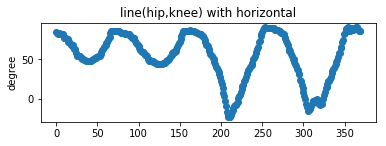

In [7]:
# post processing for mismatching


x1 = range(0, len(theta2_list))
y1 = theta2_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('line(hip,knee) with horizontal')
plt.ylabel('degree')

plt.show()

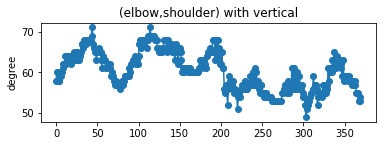

In [8]:
x1 = range(0, len(theta3_list))
y1 = theta3_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('(elbow,shoulder) with vertical')
plt.ylabel('degree')

plt.show()

In [9]:
# try to deal with each action seperately
feedbacks = []
seperate_point = []

####
# to store the frame of wrong action
feedbacks_image = []
####
# to store the whole actions
whole_actions = []
####


import peakutils
theta2_list_temp = np.array(theta2_list)
seperate_points = peakutils.indexes(theta2_list_temp, thres=0.2/max(theta2_list_temp), min_dist=65)
print(seperate_points)


[  3  76 163 253 364]


In [10]:
for index_x in range(0,len(seperate_points)-1):
    print(index_x)
    feedback_temp = ['None','None','None']
    feedback_image_temp = ['None','None','None']
    test_theta1_list =  theta1_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    test_theta2_list =  theta2_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    test_theta3_list =  theta3_list[ seperate_points[index_x] :  seperate_points[index_x+1] ]
    # store the action
    whole_actions.append(test_theta2_list )
    # theta1_list
    # check whether your body fixed
    max_theta1= max(test_theta1_list)
    min_theta1= min(test_theta1_list)
    #print( max_theta2, min_theta2 )
    max_index = theta1_list.index(max_theta1)
    if (max_theta1 >= 50 ) :
        feedback_image_temp[0]=index_count[max_index]
        feedback_temp[0]=( 'Learning forward too much while squating.It is better to lower '+str(round(max_theta1 -45))+' degrees!' )   
    elif ( 20 <= max_theta1 < 35 ) :
        feedback_image_temp[0]=index_count[max_index]
        feedback_temp[0]=( 'Learning forward not enough while squating.It is better to increase '+str(round(40-max_theta1))+' degrees!' )      

    # theta2_list
    max_theta2 = max(test_theta2_list)
    min_theta2 = min(test_theta2_list)
    print( max_theta2, min_theta2 )
    min_index = theta2_list.index(min_theta2)
    if (min_theta2 < 0):
        print('fuck')
        feedback_image_temp[1]=index_count[min_index]
        feedback_temp[1]=( 'Squating too much. Your leg should be parallel to the horizontal!' )   
    elif (25 <= min_theta2):
        feedback_image_temp[1]=index_count[min_index]
        feedback_temp[1]=( 'Squating not enough. Your leg should be parallel to the horizontal!' )   
        
    # theta3_list
    max_theta3= max(test_theta3_list)
    min_theta3= min(test_theta3_list)
    #print(max_theta1,min_theta1)
    if (max_theta3- min_theta3> 30):
        feedback_temp[2]=('Keep your arms close to your body!')
    feedbacks.append(feedback_temp)
    feedbacks_image.append(feedback_image_temp)

0
87.0 48.0
1
87.0 44.0
2
90.0 -24.0
fuck
3
91.0 -16.0
fuck


In [11]:
print(feedbacks)
print(feedbacks_image)

[['Learning forward not enough while squating.It is better to increase 14.0 degrees!', 'Squating not enough. Your leg should be parallel to the horizontal!', 'None'], ['Learning forward not enough while squating.It is better to increase 13.0 degrees!', 'Squating not enough. Your leg should be parallel to the horizontal!', 'None'], ['None', 'Squating too much. Your leg should be parallel to the horizontal!', 'None'], ['None', 'Squating too much. Your leg should be parallel to the horizontal!', 'None']]
[['output_video/squat_wrong/0066.jpg', 'output_video/squat_wrong/0072.jpg', 'None'], ['output_video/squat_wrong/0236.jpg', 'output_video/squat_wrong/0244.jpg', 'None'], ['None', 'output_video/squat_wrong/0420.jpg', 'None'], ['None', 'output_video/squat_wrong/0612.jpg', 'None']]


In the 1 turn, you have several problems:
~~~~~~~~~~~~~~~~~~~~~~
In the 2 turn, you have several problems:
 Learning forward not enough while squating.It is better to increase 13.0 degrees!


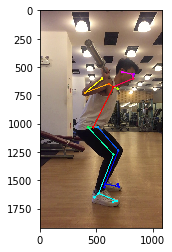

 Squating not enough. Your leg should be parallel to the horizontal!


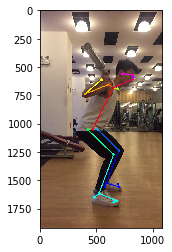

~~~~~~~~~~~~~~~~~~~~~~
In the 3 turn, you have several problems:
~~~~~~~~~~~~~~~~~~~~~~
In the 4 turn, you have several problems:
~~~~~~~~~~~~~~~~~~~~~~


In [16]:
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 4.0)
for each_x in range(len(seperate_points)-1):
    print("In the "+ str(each_x+1) +" turn, you have several problems:")
    feedback = feedbacks[each_x]
    image_part = feedbacks_image[each_x]
    if feedback == ['None','None','None']:
        print('Good Jobs!!!!!')
    else:
        for each_y in range(len(feedback)):
            if feedback[each_y] != 'None':
                
                if image_part[each_y] != 'None':
                    if each_x ==1 :
                        print('\033[1;35m',feedback[each_y])
                        #print(image_part[each_y])
                        img = cv2.imread(image_part[each_y])
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        plt.imshow(img)
                        plt.show()
                else:
                    print(feedback[each_y])

    print('~~~~~~~~~~~~~~~~~~~~~~')

In [13]:
# now using the Dynamic time warping to compare the similarity to the standard action
# the above action part(theta list) is stored in whole_actions
#np.savetxt('a.txt',a,fmt='%0.8f')
#for x in whole_actions:
#print(len(whole_actions))
#for i in range(len(whole_actions)):
#    name = 'squat_template/test'+str(i)+'.txt'
#    np.savetxt(name, whole_actions[i])